In [51]:
import numpy as np
import scipy.constants as const
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad

In [12]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [3]:
statesN2 = ["N2(X1Sigmag+)","N2(A3Sigmau+)","N2(B3Pig)","N2(W3Deltau)","N2(Bp3Sigmau-)",
            "N2(ap1Sigmau-)","N2(a1Pig)","N2(w1Deltau)","N2(C3Piu)","N2(E3Sigmag+)","N2(D3Sigmau+)"]
statesN2p = ["N2+(X2Sigmag+)","N2+(A2Piu)","N2+(B2Sigmau+)","N2+(C2Sigmau+)"]

vibConstantsN2 = [[0.0, 2358.57, 14.324, -2.26E-3, -2.4E-4, 0],
                 [49754.8, 1460.48, 13.775, -1.175E-2, 1.41E-4, -7.29E-5],
                 [59306.8, 1734.38, 14.558, 1.40E-2, -1.13E-3, 0],
                 [59380.2, 1506.53, 12.575, 3.09E-2, -7.1E-4, 0],
                 [65851.3, 1516.88, 12.181, 4.19E-2, -7.3E-4, 0],
                 [67739.3, 1530.25, 12.075, 4.13E-2, -2.9E-4, 0],
                 [68951.2, 1694.21, 13.949, 7.94E-3, 2.9E-4, 0],
                 [71698.4, 1559.50, 12.008, 4.54E-2, 0, 0],
                 [88977.9, 2047.18, 28.445, 2.0883, -5.350E-1, 0],
                 [95774.5, 2218, 16.3, -2.7E-2, -2.6E-3, 0],
                 [103570.9, 2207, 16.3, -2.7E-2, -2.6E-3, 0]]

vibConstantsN2p = [[125667.5, 2207.37, 16.302, -2.67E-3, -2.61E-3, 3.7E-5],
                  [134683.1, 1903.51, 15.029, 2.03E-3, 0, 0],
                  [151233.5, 2420.83, 23.851, -0.3587, -6.192E-2, 0],
                  [190209.5, 2071.5, 9.29, -0.43, 0, 0]]

rotConstantsN2 = [[1.99824, 1.7318E-2, -3.3E-5, 0, 0],
                 [1.45499, 1.8385E-2, 1.24E-5, -6.7E-6, 0],
                 [1.63802, 1.8302E-2, -8.4E-6, -3.4E-6, 0],
                 [1.47021, 1.6997E-2, -1.01E-5, 3.3E-7, 0],
                 [1.4731, 1.668E-2, 1.84E-5, -4.5E-7, 0],
                 [1.4799, 1.657E-2, 2.41E-5, 0, 0],
                 [1.6169, 1.793E-2, -2.93E-5, 0, 0],
                 [1.4963, 1.63E-2, 0, 0, 0],
                 [1.8247, 1.868E-2, -2.28E-3, 7.33E-4, -1.5E-4],
                 [1.9368, 1.90E-2, -1.9E-4, 0, 0],
                 [1.9705, 1.90E-2, -1.9E-4, 0, 0]]

rotConstantsN2p = [[1.93177, 1.900E-2, -1.91E-5, -5.00E-6, 4.6E-8],
                  [1.7442, 1.838E-2, -1.76E-4, 4.4E-6, 0],
                  [2.0845, 2.132E-2, -8.5E-4, 0, 0],
                  [1.5114, 1.10E-3, -8.2E-4, 0, 0]]

In [4]:
mu=1.16294E-26
wavenumber_per_eV = 8065.6

In [5]:
def f(v, vibConstants):
    I = quad(fIntegrand,-1/2,v,args=(v, vibConstants))
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants))
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [6]:
def r(v, vibConstants, rotConstants):
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [7]:
r(0, vibConstantsN2[0], rotConstantsN2[0])

[0.1055561942715914, 0.11461491293899788]

In [65]:
PES = []
for v in range(41):
    rv=r(v, vibConstantsN2[0], rotConstantsN2[0])
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2[0]
    Gvv=Gv(v,we,wexe,weye,weze)/wavenumber_per_eV
    PES.append([rv[0],Gvv])
    PES.append([rv[1],Gvv])
    
PES = np.asarray(PES)

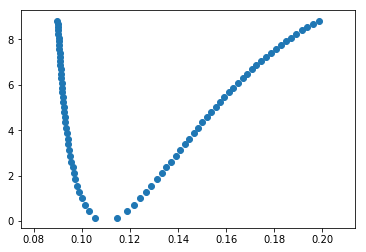

In [66]:
x, y = PES.T
plt.scatter(x,y)

In [106]:
def Jv(vArray, stateN2, stateN2p):

    N2pPES = []
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2p[stateN2p]

    for vp in range(41):
        rvp=r(vp, vibConstantsN2p[stateN2p], rotConstantsN2p[stateN2p])
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        N2pPES.insert(0, [rvp[0], Tvp])
        N2pPES.append([rvp[1], Tvp])
    
    N2pPES = np.asarray(N2pPES)
    
    I_N2pPES = interpolate.interp1d(N2pPES[:,0], N2pPES[:,1], kind='quadratic')

    JvArray = []
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2[stateN2]
    for v in vArray:
        rv=r(v, vibConstantsN2[stateN2], rotConstantsN2[stateN2])
        Tvv=Tv(v, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        JvArray.append(I_N2pPES(rv)-Tvv)
    
    return JvArray

In [107]:
Jvv=Jv(list(range(41)),0,0)

In [108]:
Jvv

[array([15.73434575, 15.49721392]),
 array([15.83486329, 15.40179933]),
 array([15.9168477 , 15.33355724]),
 array([15.99561892, 15.27372377]),
 array([16.07605179, 15.21864264]),
 array([16.16015941, 15.16647876]),
 array([16.24925375, 15.11623718]),
 array([16.34330029, 15.06729698]),
 array([16.44130574, 15.01924649]),
 array([16.54040642, 14.97178153]),
 array([16.63554763, 14.92465024]),
 array([16.71922562, 14.87765352]),
 array([16.78257142, 14.83062731]),
 array([16.81787585, 14.78343233]),
 array([16.82063794, 14.7359479 ]),
 array([16.79090464, 14.68806858]),
 array([16.7318458 , 14.63970874]),
 array([16.64814551, 14.59078613]),
 array([16.5446597 , 14.54122522]),
 array([16.42571015, 14.490961  ]),
 array([16.295016  , 14.43993872]),
 array([16.15543268, 14.38811394]),
 array([16.00936169, 14.33545407]),
 array([15.85859118, 14.28193698]),
 array([15.7047626, 14.2275451]),
 array([15.54885411, 14.17227191]),
 array([15.3920325 , 14.11612292]),
 array([15.23510308, 14.059116

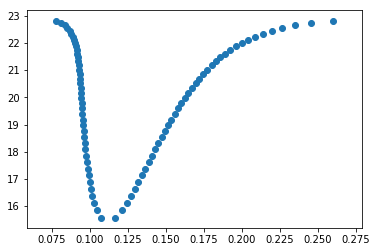

In [47]:
x,y = N2pPES.T
plt.scatter(x,y)